# Group 5K fold

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import GroupKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, average_precision_score
)
from imblearn.over_sampling import SMOTE
from tqdm import tqdm
from imblearn.over_sampling import SMOTE
# CSV 
file_path = '/Users/bg.lim/Downloads/TAMU_Agri/New_CGM/0825dataset(sleep).csv'

# 
df = pd.read_csv(file_path, encoding="utf-8")

# Convert Time_24h to float hour
df["Time_24h"] = pd.to_datetime(df["Time_24h"], format="%H:%M", errors="coerce")
df["Time_24h"] = df["Time_24h"].dt.hour + df["Time_24h"].dt.minute / 60

X_columns = [
    "15m_G_Diff_5", "15m_G_Diff_6","15m_G_Diff_7","15m_G_Diff_8",
    "15m_G_Diff_9","15m_G_Diff_10",
    "Z_Previous_5","Z_Previous_6","Z_Previous_7","Z_Previous_8","Z_Previous_9","Z_Previous_10",
    "Time_24h", "hungry", "EMA_T_Diff",'bored','How_stressed','How_tired'
    "mean_intensity_1h", "mean_intensity_2h", "mean_intensity_3h",
    "HR_mean_1h", "HR_mean_2h", "HR_mean_3h",
    "HR_std_1h", "HR_std_2h", "HR_std_3h",
    "HR_slope_1h", "HR_slope_2h", "HR_slope_3h",
    "TimeInBed", "Efficiency", "Sleep_Diff",
    "Glucose_range_pre_1_2.5h","Glucose_spread_ratio_pre_1_2.5h",
    "Glucose_skew_hint_pre_1_2.5h","Glucose_std_pre_1_2.5h",
    "Glucose_iqr_to_std_pre_1_2.5h",    
    "1_1.5h_pre_mean", "1_1.5h_pre_std", "1_1.5h_pre_slope",
    "1.5_2h_pre_mean", "1.5_2h_pre_std", "1.5_2h_pre_slope",
    "2_2.5h_pre_mean", "2_2.5h_pre_std", "2_2.5h_pre_slope",
    "Glucose_q25_pre_1_2.5h","Z_Previous_4","Z_HR", "Z_Intensity",
    "HR","Intensity", "1h_pre_Thre", "Glucose_pre_1h", "Glucose_pre_1.5h",
    "Glucose_pre_2h", "G_minus_T_pre_1.5h", "G_minus_T_pre_2h",
    "Threshold_pre_2h", "Threshold_pre_1.5h"
    
]


# Remove rows with missing values
df_model = df[X_columns + ["GE_1h", "StudyID"]].dropna()

# 기본 데이터셋 준비 (기존과 동일)
df_model = df[X_columns + ["GE_1h", "StudyID"]].dropna()
X = df_model[X_columns]
y = df_model["GE_1h"].astype(int)
groups = df_model["StudyID"]

# GroupKFold 설정
gkf = GroupKFold(n_splits=5)

# 결과 저장용 리스트
metrics = []
feature_importance_list = []

threshold = 0.3  # 고정 threshold

for fold, (train_idx, val_idx) in enumerate(gkf.split(X, y, groups)):
    print(f"\n📂 Fold {fold + 1}")

    X_train_raw, y_train_raw = X.iloc[train_idx], y.iloc[train_idx]
    X_val, y_val = X.iloc[val_idx], y.iloc[val_idx]

    # SMOTE 적용
    minority_class_size = np.bincount(y_train_raw)[1]
    k_neighbors = min(5, minority_class_size - 1) if minority_class_size > 1 else 1
    smote = SMOTE(random_state=42, k_neighbors=k_neighbors)
    X_train, y_train = smote.fit_resample(X_train_raw, y_train_raw)

    # 모델 학습
    model = RandomForestClassifier(
        n_estimators=1000,
        min_samples_split=50,
        min_samples_leaf=50,
        max_features=None,
        max_depth=50,
        criterion='entropy',
        class_weight=None,
        bootstrap=True,
        random_state=42,
        n_jobs=-1
    )
    model.fit(X_train, y_train)

    # 예측 및 평가
    y_proba = model.predict_proba(X_val)[:, 1]
    y_pred = (y_proba >= threshold).astype(int)

    metrics.append({
        "Accuracy": accuracy_score(y_val, y_pred),
        "Precision": precision_score(y_val, y_pred, zero_division=0),
        "Recall": recall_score(y_val, y_pred, zero_division=0),
        "F1": f1_score(y_val, y_pred, zero_division=0),
        "ROC AUC": roc_auc_score(y_val, y_proba),
        "PR AUC": average_precision_score(y_val, y_proba)
    })

    # Feature importance 저장
    feature_importance_list.append(model.feature_importances_)

# 평균 결과 출력
results_df = pd.DataFrame(metrics)
print("\n📊 GroupKFold (5-fold) 평균 성능:\n")
print(results_df.mean().round(4))

# Feature importance 평균
feature_importance_avg = np.mean(feature_importance_list, axis=0)
importances = pd.DataFrame({
    "Feature": X.columns,
    "Importance": feature_importance_avg
}).sort_values("Importance", ascending=False)

print("\n🔍 평균 Feature Importance (Top 15):")
print(importances.head(15))


/var/folders/r0/h30ywvr55x98xwjf49klh76m0000gp/T/ipykernel_14807/2701940912.py:17: DtypeWarning: Columns (101,102) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, encoding="utf-8")



📂 Fold 1

📂 Fold 2

📂 Fold 3

📂 Fold 4

📂 Fold 5

📊 GroupKFold (5-fold) 평균 성능:

Accuracy     0.6871
Precision    0.1395
Recall       0.4236
F1           0.2097
ROC AUC      0.6425
PR AUC       0.1449
dtype: float64

🔍 평균 Feature Importance (Top 15):
              Feature  Importance
52          Intensity    0.202159
18  mean_intensity_1h    0.128669
13             hungry    0.104310
12           Time_24h    0.051596
48       Z_Previous_4    0.033941
45     2_2.5h_pre_std    0.030458
39     1_1.5h_pre_std    0.025804
42     1.5_2h_pre_std    0.024588
16       How_stressed    0.022613
17          How_tired    0.022112
30          TimeInBed    0.020305
14         EMA_T_Diff    0.016512
32         Sleep_Diff    0.016334
2        15m_G_Diff_7    0.015241
50        Z_Intensity    0.014588


In [5]:
import joblib

# 모델 저장
joblib.dump(model, "rf_model_last_fold(0825).pkl")

# 데이터 저장
df_model.to_pickle("df_model(0825).pkl")


# Validation

In [21]:
import numpy as np
import pandas as pd
from sklearn.model_selection import GroupKFold
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from sklearn.metrics import roc_auc_score

# ===== 0) 설정 =====
FEATURES = X_columns                # 이미 정의됨
LABEL_COL = "GE_1h"                 # 현재 라벨 이름
GROUP_COL = "StudyID"
TS_COL = "Timestamp"                # df에 존재하는 타임스탬프 컬럼명

# ===== 1) df_model 정리: y_true 생성 =====
df_model_oof = df_model.copy()
if "y_true" not in df_model_oof.columns:
    df_model_oof["y_true"] = df_model_oof[LABEL_COL].astype(int)

# ===== 2) 메타정보(ts/date/hour_float) 복구 =====
ts_series = pd.to_datetime(df.loc[df_model_oof.index, TS_COL], errors="coerce")
meta = pd.DataFrame({
    "StudyID": df_model_oof[GROUP_COL].values,
    "ts": ts_series.values,
    "date": ts_series.dt.date.values,
    "hour_float": (ts_series.dt.hour + ts_series.dt.minute/60.0).values,
    "y_true": df_model_oof["y_true"].values
}).dropna(subset=["ts"])

# ===== 3) OOF 확률 계산 (GroupKFold + SMOTE 각 fold마다 적용) =====
X_all = df_model_oof[FEATURES].to_numpy()
y_all = df_model_oof["y_true"].to_numpy()
groups = df_model_oof[GROUP_COL].to_numpy()

oof_prob = np.zeros(len(df_model_oof), dtype=float)
oof_true = np.zeros(len(df_model_oof), dtype=int)

gkf = GroupKFold(n_splits=5)

for fold, (tr_idx, va_idx) in enumerate(gkf.split(X_all, y_all, groups)):
    X_tr, y_tr = X_all[tr_idx], y_all[tr_idx]
    X_va, y_va = X_all[va_idx], y_all[va_idx]

    # SMOTE (fold 내부에서만)
    cnt1 = np.bincount(y_tr)[1] if 1 in np.unique(y_tr) else 0
    if cnt1 > 1:
        k_neighbors = min(5, cnt1 - 1)
        sm = SMOTE(random_state=42, k_neighbors=k_neighbors)
        X_tr, y_tr = sm.fit_resample(X_tr, y_tr)

    model_fold = RandomForestClassifier(
        n_estimators=1000,
        min_samples_split=50,
        min_samples_leaf=50,
        max_features=None,
        max_depth=50,
        criterion='entropy',
        class_weight=None,
        bootstrap=True,
        random_state=42,
        n_jobs=-1
    )
    model_fold.fit(X_tr, y_tr)
    prob_va = model_fold.predict_proba(X_va)[:, 1]

    oof_prob[va_idx] = prob_va
    oof_true[va_idx] = y_va

    print(f"Fold {fold+1} ROC-AUC: {roc_auc_score(y_va, prob_va):.3f}")

print(f"OOF ROC-AUC (all): {roc_auc_score(oof_true, oof_prob):.3f}")

# ===== 4) pred_df_oof 생성 (정책 함수가 요구하는 칼럼들 포함) =====
pred_df_oof = meta.copy()
pred_df_oof["y_prob"] = oof_prob

need_cols = {"StudyID","ts","date","hour_float","y_true","y_prob"}
missing = need_cols - set(pred_df_oof.columns)
assert not missing, f"pred_df_oof missing columns: {missing}"

# ===== 5) 정책 적용 =====
def summarize_alerts_table(alerts_df: pd.DataFrame):
    if alerts_df is None or alerts_df.empty:
        print("No alerts after policy.")
        empty = pd.DataFrame(columns=["StudyID","UniqueDays","TotalAlerts","Alerts_per_day_mean","Alerts_per_day_median"])
        return empty, np.nan

    per_pid_day = alerts_df.groupby(["StudyID","date"]).size().reset_index(name="alerts")
    per_pid = (per_pid_day.groupby("StudyID")["alerts"]
               .agg(UniqueDays="count", TotalAlerts="sum",
                    Alerts_per_day_mean="mean", Alerts_per_day_median="median")
               .reset_index())

    success_rate = float(alerts_df["success"].mean())

    print("\n=== Policy-level alert summary (TABLE) ===")
    print(f"Total alerts: {len(alerts_df)}")
    print(f"Overall success rate: {success_rate:.3f}")
    print(f"Median alerts/day across participants: {per_pid['Alerts_per_day_median'].median():.2f}")
    print(f"Mean alerts/day across participants: {per_pid['Alerts_per_day_mean'].mean():.2f}")

    return per_pid, success_rate

def generate_alerts_with_policy_fast(
    pdf: pd.DataFrame,
    threshold: float = 0.3,
    min_hour: float = 8.0,
    max_hour: float = 22.0,
    require_two_hits: bool = True,
    two_hit_window_min: int = 30,
    cooldown_min: int = 120,
    per_day_cap: int = 4,
    high_conf_single_hit_prob: float = None
):
    need_cols = ["StudyID","ts","date","y_true","y_prob","hour_float"]
    if not set(need_cols).issubset(pdf.columns):
        raise KeyError(f"pred_df_oof missing {list(set(need_cols)-set(pdf.columns))}")

    d = pdf.loc[(pdf["hour_float"] >= min_hour) & (pdf["hour_float"] <= max_hour), need_cols].copy()
    d["is_pos"] = (d["y_prob"] >= threshold).astype(np.uint8)
    d = d[d["is_pos"] == 1]
    if d.empty:
        return pd.DataFrame(columns=["StudyID","ts","date","y_true_at_alert","y_prob_at_alert","success"])

    alerts = []
    for (pid, day), g in d.sort_values(["StudyID","date","ts"]).groupby(["StudyID","date"]):
        times = g["ts"].to_numpy()
        probs = g["y_prob"].to_numpy(dtype=float)
        yts   = g["y_true"].to_numpy(dtype=int)

        if require_two_hits:
            win = np.timedelta64(two_hit_window_min, "m")
            j_right = np.searchsorted(times, times + win, side="right") - 1
            has_pair = (j_right > np.arange(len(times)))
            has_pair &= (times[j_right] - times) <= win

            if high_conf_single_hit_prob is not None:
                high_conf = probs >= float(high_conf_single_hit_prob)
                cand_mask = has_pair | high_conf
            else:
                cand_mask = has_pair

            if not np.any(cand_mask):
                continue
            cand_idx = np.nonzero(cand_mask)[0]
        else:
            cand_idx = np.arange(len(times))

        selected = []
        if len(cand_idx) > 0:
            cooldown = np.timedelta64(cooldown_min, "m")
            last_alert_time = times[0] - cooldown - np.timedelta64(1, "m")
            # 확률 높은 순으로 선택 (time 우선이면 probs 대신 times로 정렬)
            for i in cand_idx[np.argsort(-probs[cand_idx])]:
                if times[i] - last_alert_time < cooldown:
                    continue
                selected.append(i)
                last_alert_time = times[i]
                if len(selected) >= per_day_cap:
                    break

        if not selected:
            continue
        for i in selected:
            alerts.append({
                "StudyID": pid, "ts": times[i], "date": day,
                "y_true_at_alert": int(yts[i]),
                "y_prob_at_alert": float(probs[i])
            })

    if not alerts:
        return pd.DataFrame(columns=["StudyID","ts","date","y_true_at_alert","y_prob_at_alert","success"])

    alerts_df = pd.DataFrame(alerts)
    alerts_df["success"] = alerts_df["y_true_at_alert"].astype(int)
    return alerts_df

# 너의 S1 정책 그대로
S1 = dict(
    threshold=0.30,
    min_hour=8.0, max_hour=22.0,
    require_two_hits=True,
    two_hit_window_min=45,
    cooldown_min=90,
    per_day_cap=5,
    high_conf_single_hit_prob=0.60
)

alerts_S1 = generate_alerts_with_policy_fast(pred_df_oof, **S1)
per_pid_S1, sr_S1 = summarize_alerts_table(alerts_S1)

tp = int(alerts_S1["success"].sum())
total = len(alerts_S1)
print(f"Event-level: TP={tp}, FP={total - tp}, Total={total} (SR={tp/total:.3f})")


Fold 1 ROC-AUC: 0.656
Fold 2 ROC-AUC: 0.631
Fold 3 ROC-AUC: 0.624
Fold 4 ROC-AUC: 0.638
Fold 5 ROC-AUC: 0.667
OOF ROC-AUC (all): 0.643

=== Policy-level alert summary (TABLE) ===
Total alerts: 692
Overall success rate: 0.140
Median alerts/day across participants: 2.00
Mean alerts/day across participants: 2.09
Event-level: TP=97, FP=595, Total=692 (SR=0.140)


In [48]:
pred_df_oof.to_parquet("pred_df_oof.parquet", index=False)  # 또는 .csv
# 나중에 재사용
# pred_df_oof = pd.read_parquet("pred_df_oof.parquet")


# Success - +60min Window

In [68]:
# ===== (+60분 윈도우 성공판정용 베이스 DF, 라벨 정규화 포함) =====
pdf_base = df[[GROUP_COL, TS_COL, LABEL_COL]].copy()          # ['StudyID','Timestamp','GE_1h']
pdf_base = pdf_base.rename(columns={TS_COL: "ts", LABEL_COL: "y_true"})
pdf_base["ts"] = pd.to_datetime(pdf_base["ts"], errors="coerce")

# 0/1/float/bool/NaN 혼재를 안전하게 정규화
# - 숫자가 아니면 NaN으로
# - NaN은 0으로 간주(성공판정에선 양성만 필요)
# - 0/1 외 값은 0/1로 이진화(>=0.5를 1로)
pdf_base["y_true"] = pd.to_numeric(pdf_base["y_true"], errors="coerce")
pdf_base["y_true"] = (pdf_base["y_true"].fillna(0) >= 0.5).astype(np.uint8)

# ts 결측 제거 및 정렬
pdf_base = pdf_base.dropna(subset=["ts"]).sort_values(["StudyID","ts"]).reset_index(drop=True)


In [74]:
alerts_S1 = alerts_S1.copy()
alerts_S1["ts"] = pd.to_datetime(alerts_S1["ts"], errors="coerce")
alerts_S1 = alerts_S1.dropna(subset=["ts"]).sort_values(["StudyID","ts"]).reset_index(drop=True)

alerts_S1_60 = mark_success_60min_dedup(alerts_S1, pdf_base, window_min=60)

print("\n--- Using SAME alerts_S1 (policy output) ---")

_ = summarize_success_col(alerts_S1_60, "success_60m_dedup")   # 변경: +60분 윈도우 & dedup



--- Using SAME alerts_S1 (policy output) ---
[Success=success_60m_dedup] TP=185, FP=507, Total=692 (SR=0.267)


In [86]:
def summarize_success_col(alerts_df: pd.DataFrame, success_col: str, window_min=None) -> dict:
    total = len(alerts_df)
    tp = int(alerts_df[success_col].sum()) if total else 0
    fp = total - tp
    sr = (tp / total) if total else float("nan")
    if window_min:
        print(f"[Window={window_min} min] TP={tp}, FP={fp}, Total={total} (SR={sr:.3f})")
    else:
        print(f"[Success={success_col}] TP={tp}, FP={fp}, Total={total} (SR={sr:.3f})")
    return {"TP": tp, "FP": fp, "Total": total, "SR": sr}
alerts_S1_120 = mark_success_60min_dedup(alerts_S1, pdf_base, window_min=120)
_ = summarize_success_col(alerts_S1_120, "success_60m_dedup", window_min=120)


[Window=120 min] TP=242, FP=450, Total=692 (SR=0.350)


# Clustering

/opt/anaconda3/envs/jupyter_env/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/opt/anaconda3/envs/jupyter_env/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/opt/anaconda3/envs/jupyter_env/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/opt/anaconda3/envs/jupyter_env/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default valu

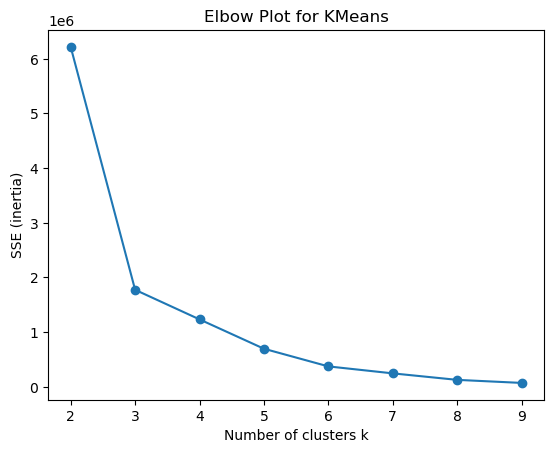

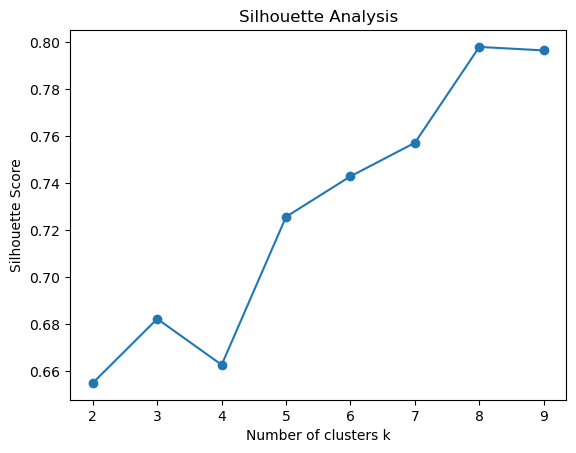

In [131]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

# ===== 1) TP / FP 데이터 분리 =====
# alerts_S1_120 : 알람과 라벨 성공여부 포함
tp_idx = alerts_S1_120[alerts_S1_120["success_60m_dedup"] == 1].index
fp_idx = alerts_S1_120[alerts_S1_120["success_60m_dedup"] == 0].index

# 분석용 변수 선택 (예: Coxman 변수들)
# 여기서는 예시로 glucose/HR/sleep 관련 피처만 뽑음
analysis_vars = ["Intensity", "mean_intensity_1h","Time_24h",
    "TimeInBed", "Sleep_Diff",
    "Glucose_std_pre_1_2.5h",
    "Z_Previous_4", "Z_Intensity",
    "hungry",  "2_2.5h_pre_std","1_1.5h_pre_std","1.5_2h_pre_std"    
]

tp_df = df_model.loc[tp_idx, analysis_vars].dropna()
fp_df = df_model.loc[fp_idx, analysis_vars].dropna()

# ===== 2) K-means 최적 k 탐색 =====
X = pd.concat([tp_df, fp_df], axis=0).to_numpy()

sse = []
sil_scores = []
K = range(2, 10)

for k in K:
    km = KMeans(n_clusters=k, random_state=42)
    labels = km.fit_predict(X)
    sse.append(km.inertia_)   # 엘보우용
    sil_scores.append(silhouette_score(X, labels))  # 실루엣 점수

# 엘보우 플롯
plt.figure()
plt.plot(K, sse, 'o-')
plt.xlabel("Number of clusters k")
plt.ylabel("SSE (inertia)")
plt.title("Elbow Plot for KMeans")
plt.show()

# 실루엣 점수
plt.figure()
plt.plot(K, sil_scores, 'o-')
plt.xlabel("Number of clusters k")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Analysis")
plt.show()




/opt/anaconda3/envs/jupyter_env/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


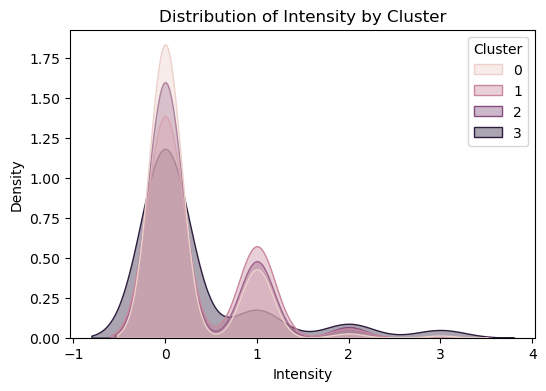

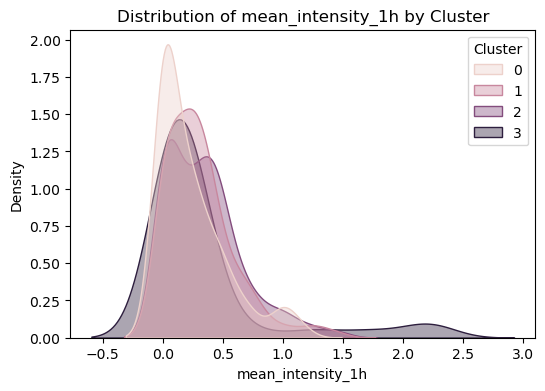

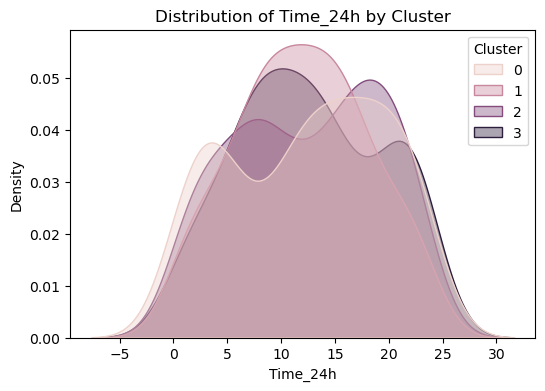

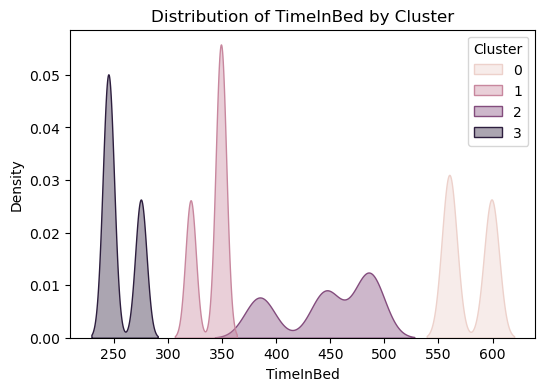

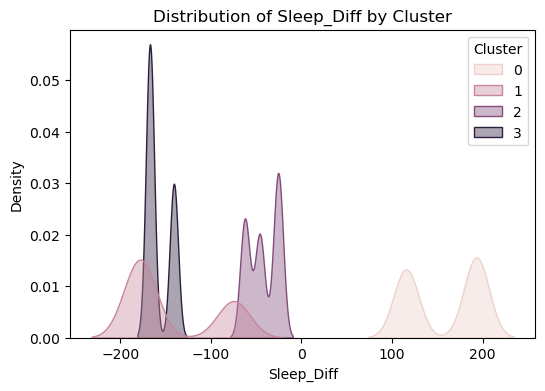

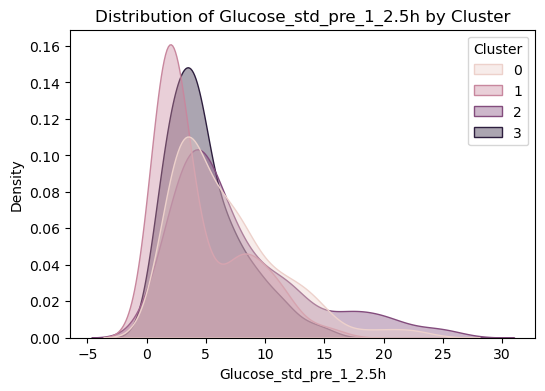

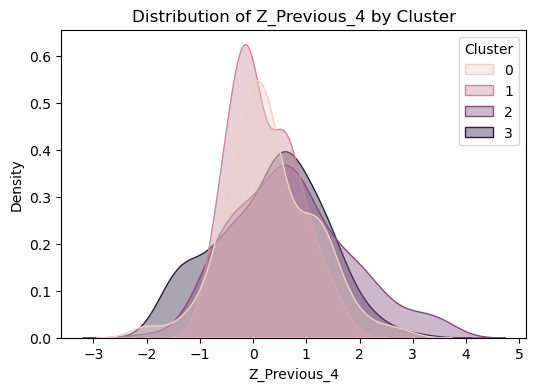

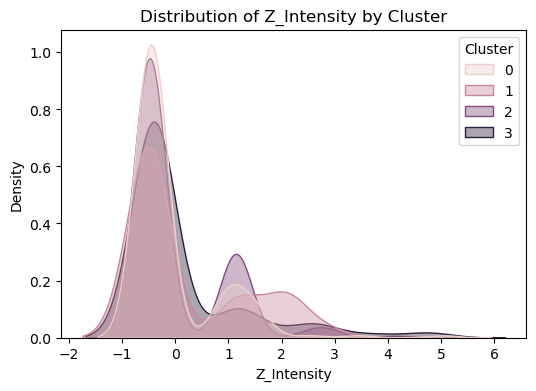

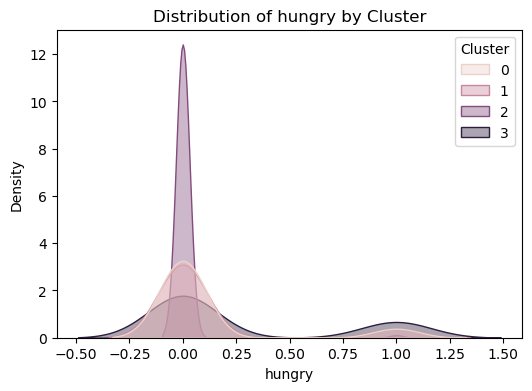

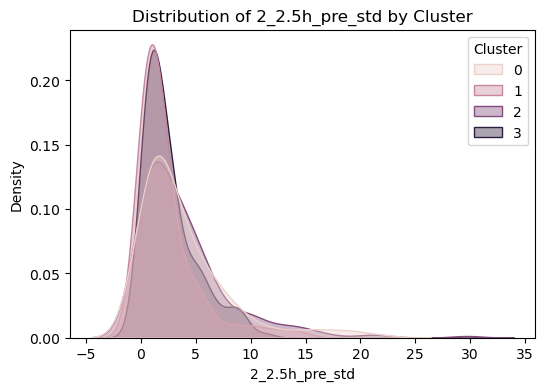

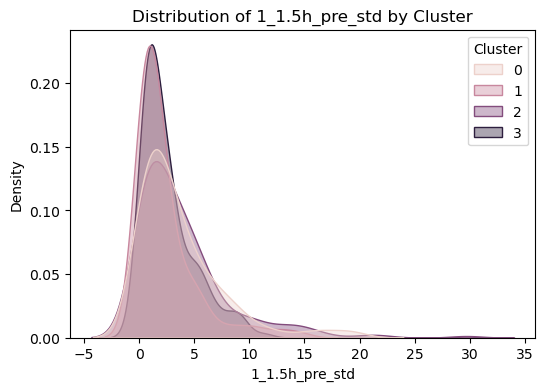

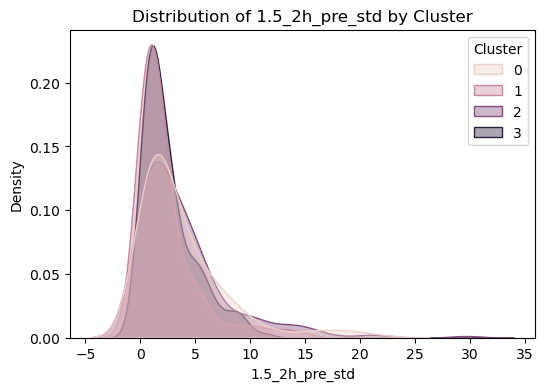

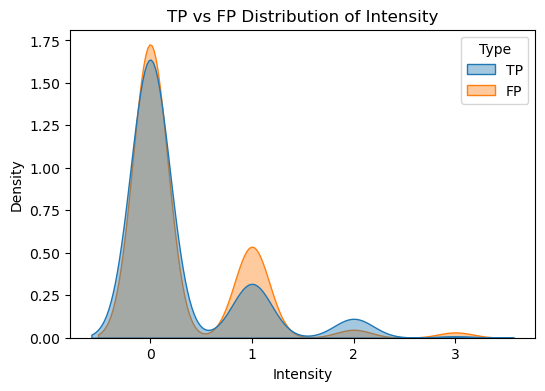

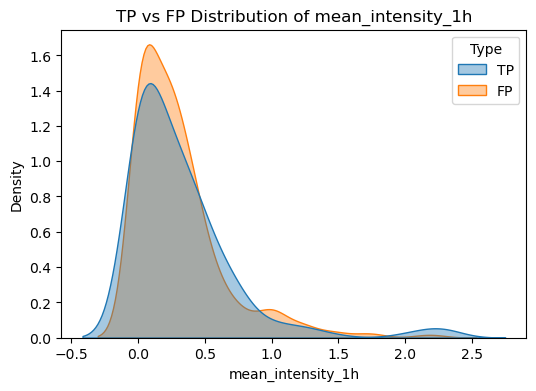

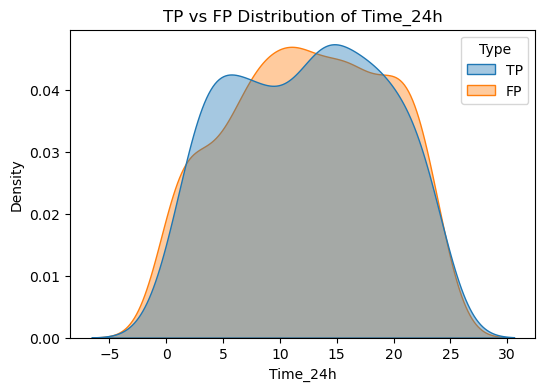

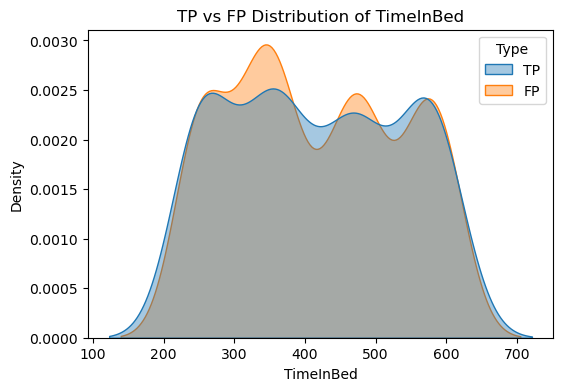

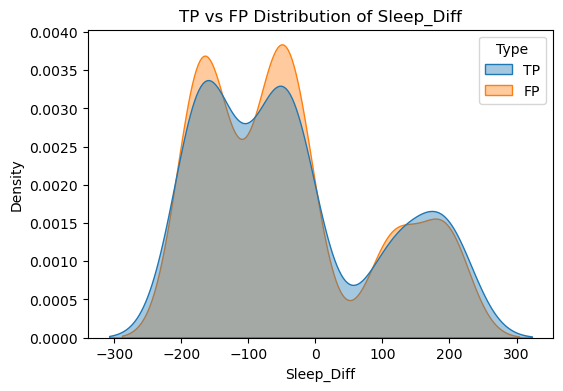

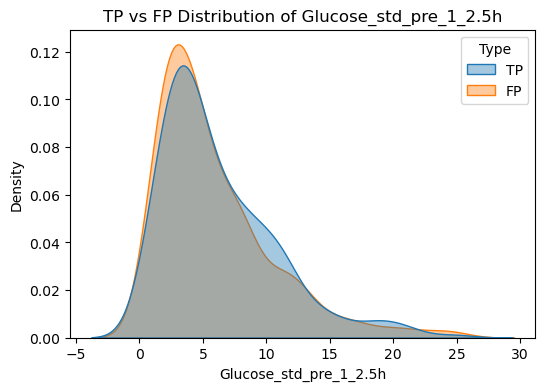

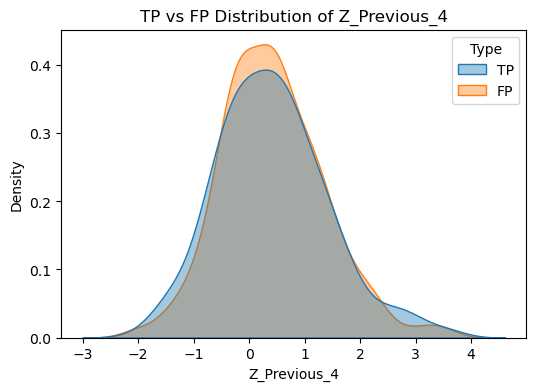

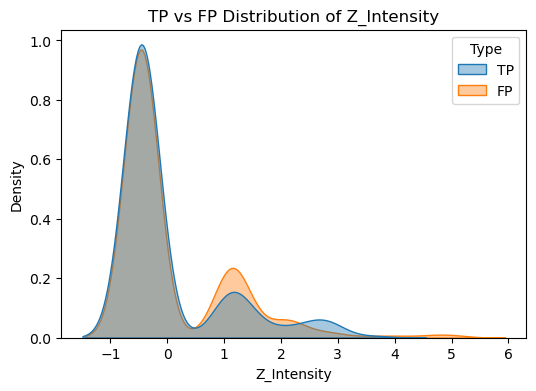

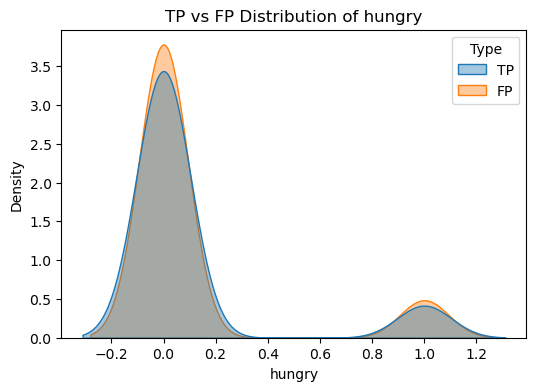

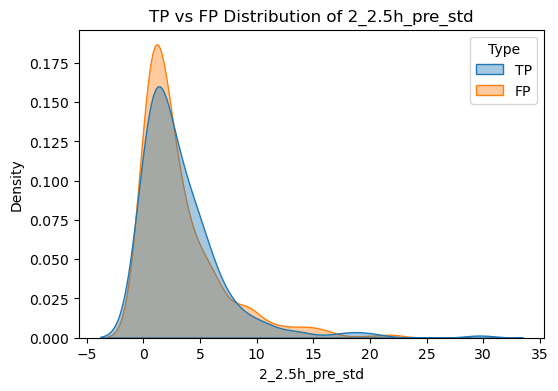

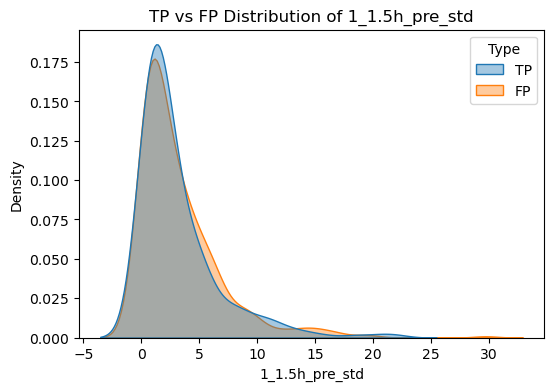

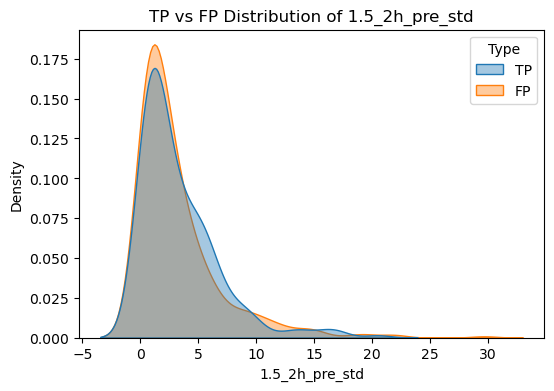

In [133]:
# ===== 3)  k=4
best_k = 4
km = KMeans(n_clusters=best_k, random_state=42)
cluster_labels = km.fit_predict(X)

# 클러스터 결과 DataFrame 정리
cluster_df = pd.concat([pd.DataFrame(X, columns=analysis_vars)], axis=1)
cluster_df["Cluster"] = cluster_labels
cluster_df["Type"] = ["TP"]*len(tp_df) + ["FP"]*len(fp_df)

# ===== 4) 변수별 클러스터 분포 시각화 =====
for var in analysis_vars:
    plt.figure(figsize=(6,4))
    sns.kdeplot(data=cluster_df, x=var, hue="Cluster", common_norm=False, fill=True, alpha=0.4)
    plt.title(f"Distribution of {var} by Cluster")
    plt.show()

# ===== 5) TP vs FP 분포 비교 =====
for var in analysis_vars:
    plt.figure(figsize=(6,4))
    sns.kdeplot(data=cluster_df, x=var, hue="Type", common_norm=False, fill=True, alpha=0.4)
    plt.title(f"TP vs FP Distribution of {var}")
    plt.show()

[KMeans] k=4, silhouette=0.207, samples=692

=== Cluster summary (k=4) ===
   Cluster    n   TP   FP     SR
0        0  381  141  240  0.370
1        1  167   51  116  0.305
2        2   69   26   43  0.377
3        3   75   24   51  0.320


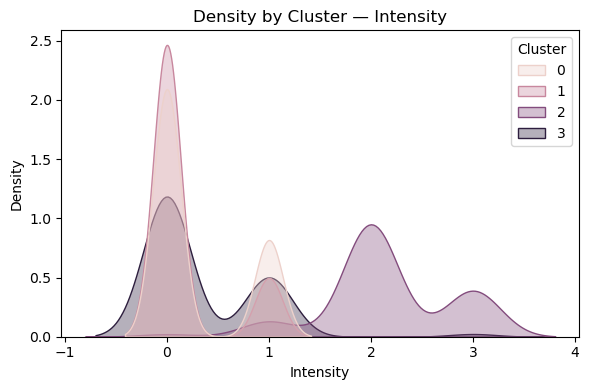

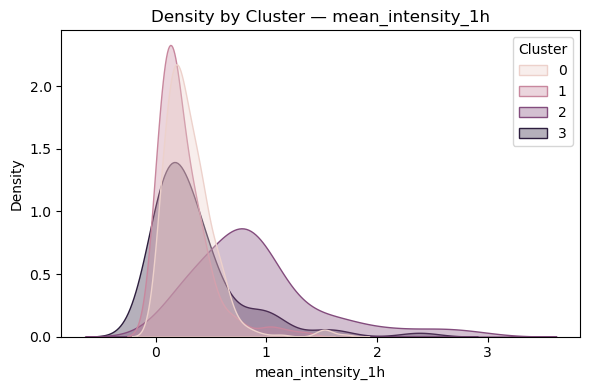

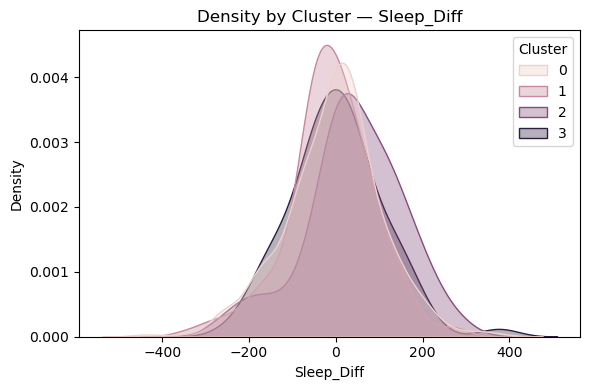

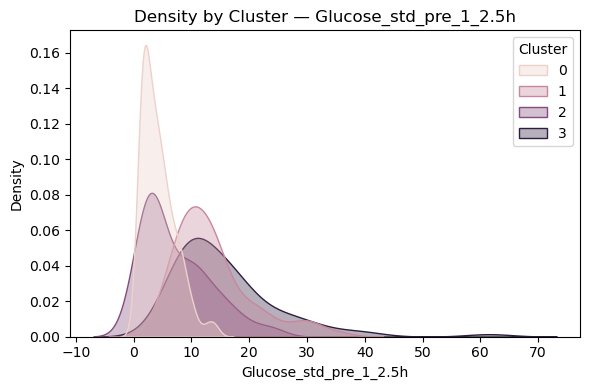

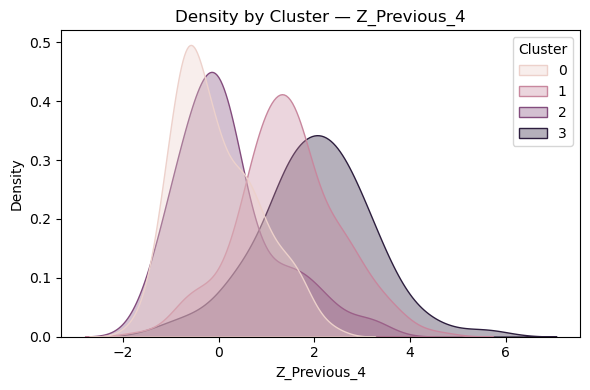

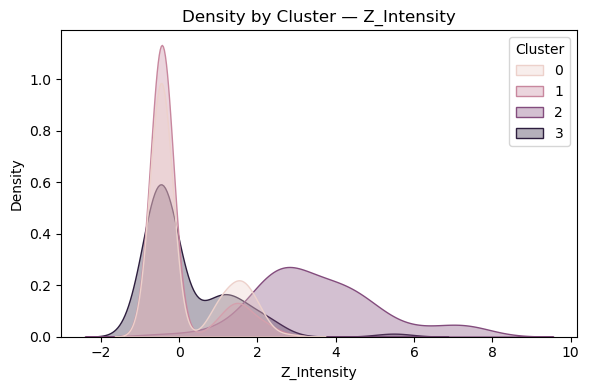

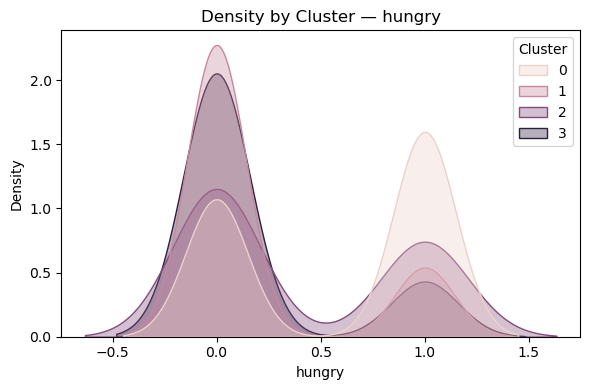

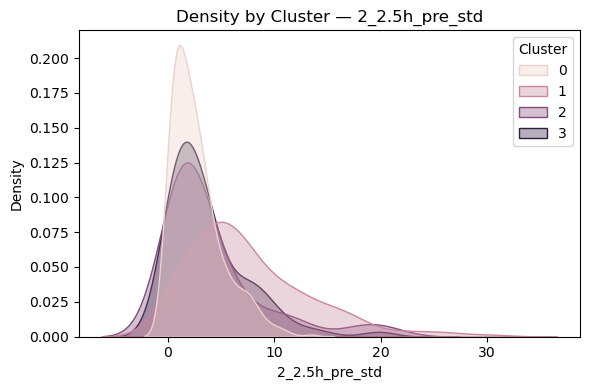

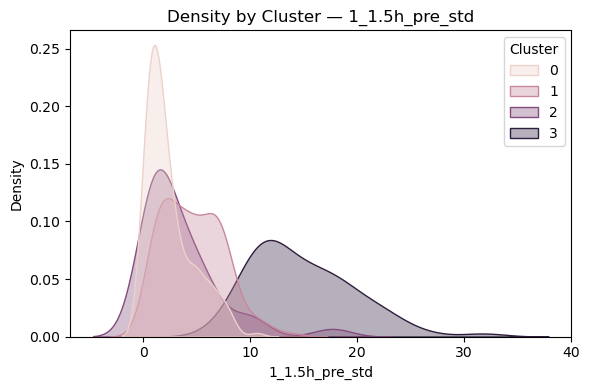

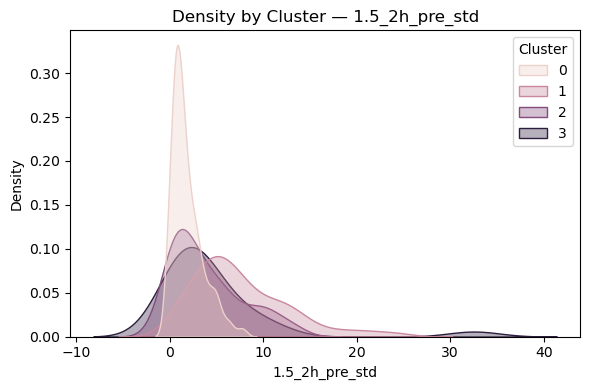

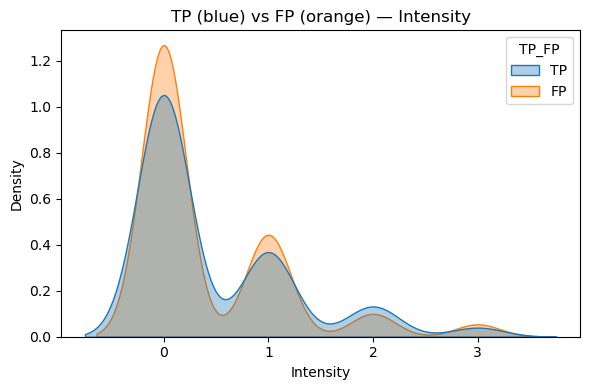

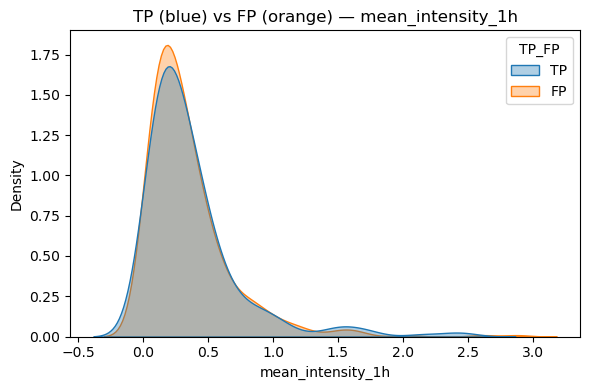

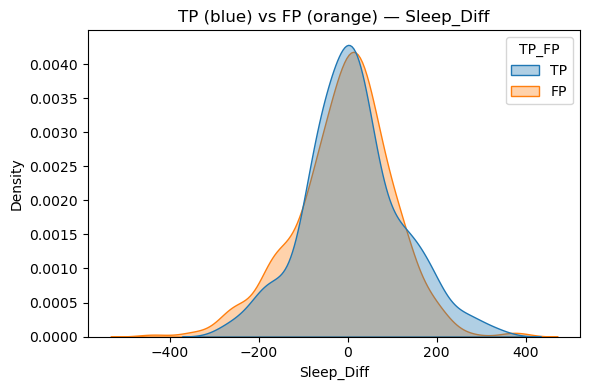

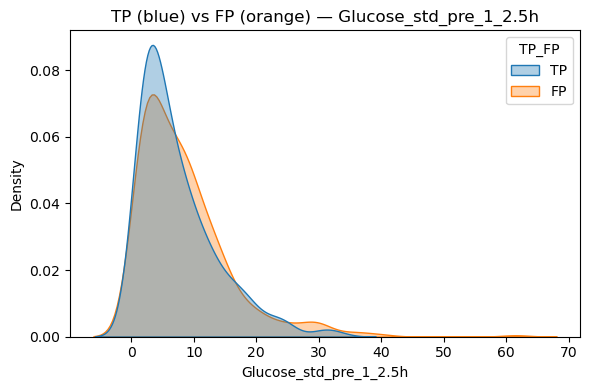

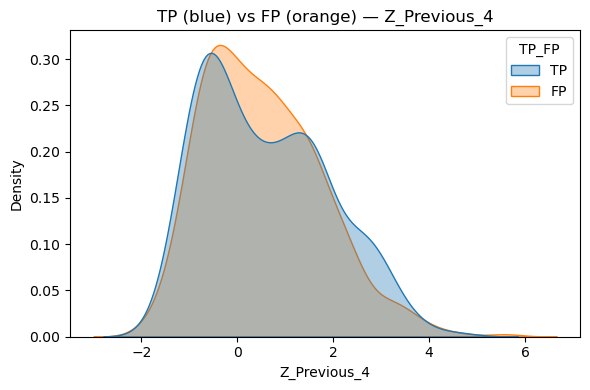

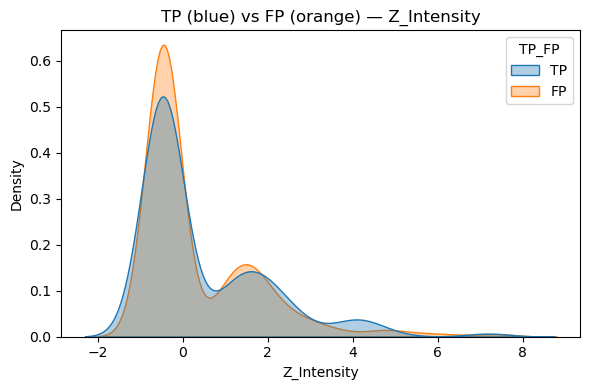

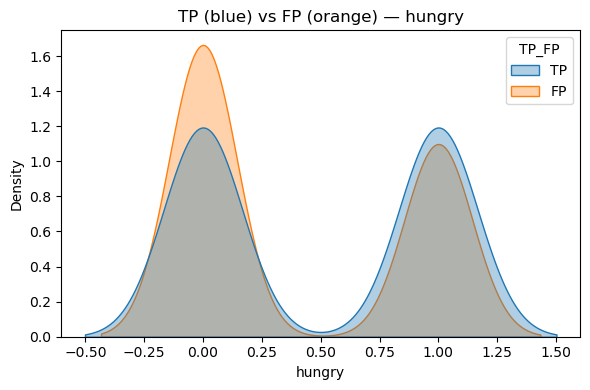

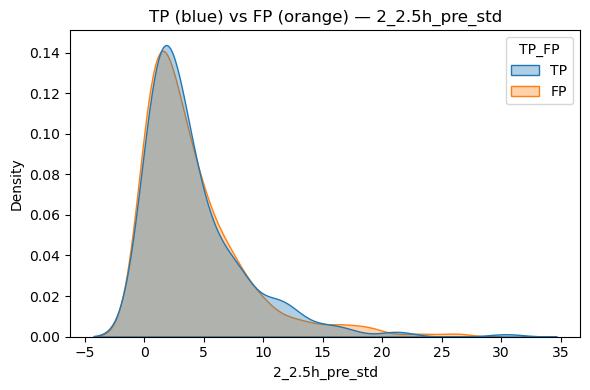

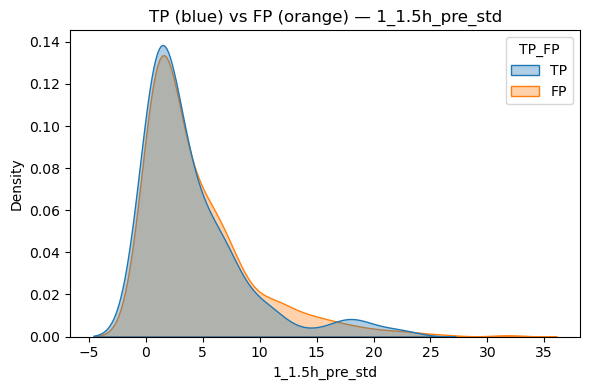

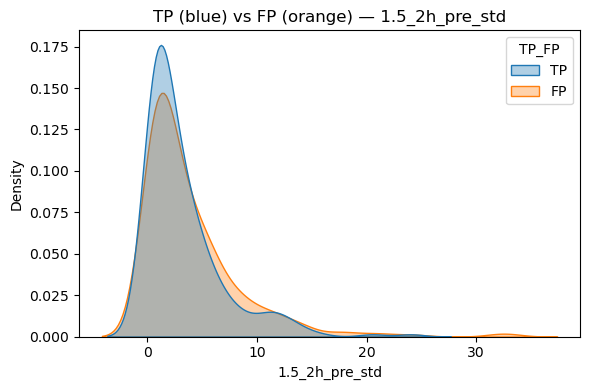

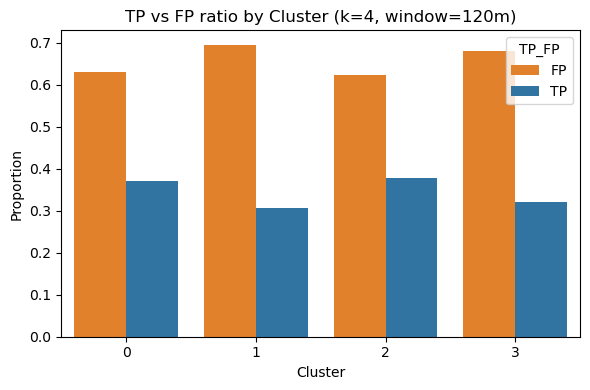

In [137]:
# ===== 0) 준비 =====
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

analysis_vars = [
    # Coxman 변수(예시) — BG 상황에 맞춰 바꿔도 OK
    "Intensity", "mean_intensity_1h","Time_24h"
    "TimeInBed", "Sleep_Diff",
    "Glucose_std_pre_1_2.5h",
    "Z_Previous_4", "Z_Intensity",
    "hungry",  "2_2.5h_pre_std","1_1.5h_pre_std","1.5_2h_pre_std"    
]
# 실제 존재하는 컬럼만 사용
analysis_vars = [c for c in analysis_vars if c in df_model_oof.columns]
assert len(analysis_vars) > 0, "analysis_vars에서 사용할 수 있는 컬럼이 없습니다."

# ===== 1) df_model_oof에 ts를 안전하게 붙이기 (StudyID+원본 df 인덱스 기반) =====
# df_model_oof와 df는 같은 행 인덱스 기준으로 만들어진 것으로 가정 (이전에 OOF 만들 때 쓴 index)
TS_COL = "Timestamp"
GROUP_COL = "StudyID"

ts_series = pd.to_datetime(df.loc[df_model_oof.index, TS_COL], errors="coerce")
meta_rows = pd.DataFrame({
    "row_id": df_model_oof.index.values,    # 원본 인덱스 추적용
    "StudyID": df_model_oof[GROUP_COL].values,
    "ts": ts_series.values
}).dropna(subset=["ts"])

# ===== 2) 알람(120분 성공판정 포함)과 feature를 조인 =====
alerts = alerts_S1_120.copy()
alerts["ts"] = pd.to_datetime(alerts["ts"], errors="coerce")
alerts = alerts.dropna(subset=["ts"])

# (StudyID, ts)로 row_id 매핑 후 feature 조인
a = alerts.merge(meta_rows, on=["StudyID","ts"], how="inner")
feats = df_model_oof.loc[a["row_id"], analysis_vars].reset_index(drop=True)
A = pd.concat([
    a[["StudyID","ts","success_60m_dedup"]].reset_index(drop=True),
    feats
], axis=1)

# ===== 3) 스케일링 + KMeans(K=4) =====
X = A[analysis_vars].astype(float).to_numpy()
scaler = StandardScaler()
Xz = scaler.fit_transform(X)

k = 4
kmeans = KMeans(n_clusters=k, random_state=42, n_init="auto")
A["Cluster"] = kmeans.fit_predict(Xz)

sil = silhouette_score(Xz, A["Cluster"])
print(f"[KMeans] k={k}, silhouette={sil:.3f}, samples={len(A)}")

# ===== 4) 클러스터 요약 (크기, TP율) =====
A["is_TP"] = (A["success_60m_dedup"] == 1).astype(int)
summary = (A.groupby("Cluster")
             .agg(n=("is_TP","size"),
                  TP=("is_TP","sum"),
                  FP=("is_TP", lambda s: int(len(s) - s.sum())),
                  SR=("is_TP","mean"))
             .reset_index()
             .sort_values("Cluster"))
summary["SR"] = summary["SR"].round(3)
print("\n=== Cluster summary (k=4) ===")
print(summary)

# ===== 5) 변수별 클러스터 분포 (겹쳐 그린 밀도) =====
for var in analysis_vars:
    plt.figure(figsize=(6,4))
    sns.kdeplot(data=A, x=var, hue="Cluster", common_norm=False, fill=True, alpha=0.35)
    plt.title(f"Density by Cluster — {var}")
    plt.tight_layout()
    plt.show()

# ===== 6) TP vs FP 분포 비교 (전체, 변수별) =====
A["TP_FP"] = np.where(A["success_60m_dedup"] == 1, "TP", "FP")

for var in analysis_vars:
    plt.figure(figsize=(6,4))
    sns.kdeplot(data=A, x=var, hue="TP_FP",
                palette={"TP":"tab:blue","FP":"tab:orange"},
                common_norm=False, fill=True, alpha=0.35)
    plt.title(f"TP (blue) vs FP (orange) — {var}")
    plt.tight_layout()
    plt.show()

# ===== 7) 클러스터별 TP율 바 차트 =====
summary_named = (A.groupby("Cluster")["TP_FP"]
                   .value_counts(normalize=True)
                   .rename("ratio")
                   .reset_index())

plt.figure(figsize=(6,4))
sns.barplot(data=summary_named, x="Cluster", y="ratio", hue="TP_FP",
            palette={"TP":"tab:blue","FP":"tab:orange"})
plt.xlabel("Cluster")
plt.ylabel("Proportion")
plt.title("TP vs FP ratio by Cluster (k=4, window=120m)")
plt.tight_layout()
plt.show()

# Cluster + TP/FP

/opt/anaconda3/envs/jupyter_env/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/var/folders/r0/h30ywvr55x98xwjf49klh76m0000gp/T/ipykernel_14807/4216514217.py:31: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


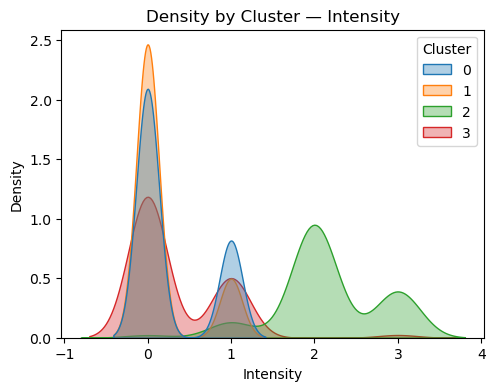

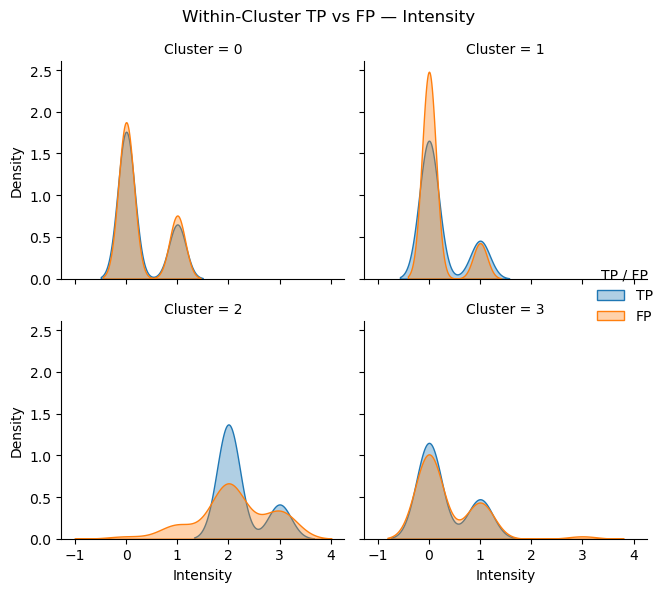

/opt/anaconda3/envs/jupyter_env/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/var/folders/r0/h30ywvr55x98xwjf49klh76m0000gp/T/ipykernel_14807/4216514217.py:31: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


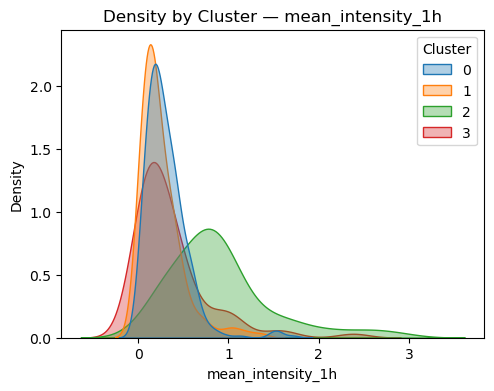

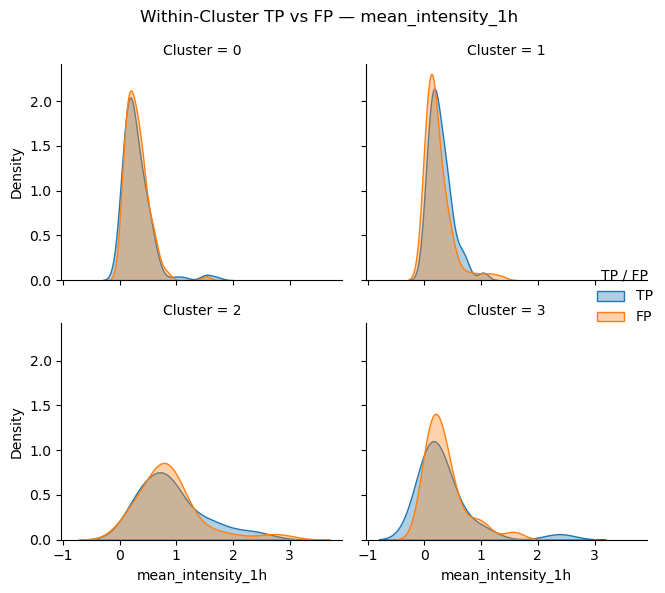

/opt/anaconda3/envs/jupyter_env/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/var/folders/r0/h30ywvr55x98xwjf49klh76m0000gp/T/ipykernel_14807/4216514217.py:31: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


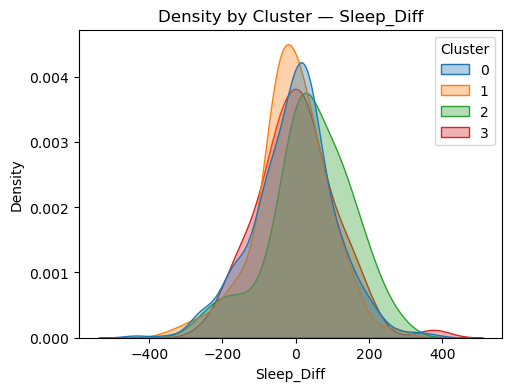

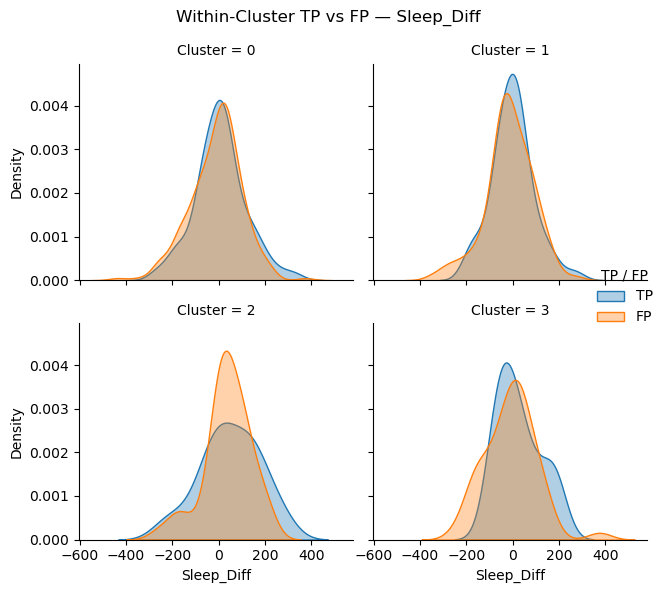

/opt/anaconda3/envs/jupyter_env/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/var/folders/r0/h30ywvr55x98xwjf49klh76m0000gp/T/ipykernel_14807/4216514217.py:31: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


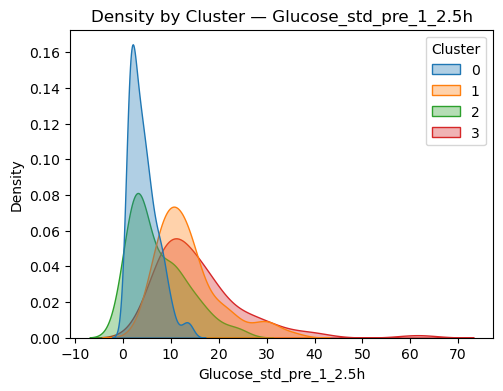

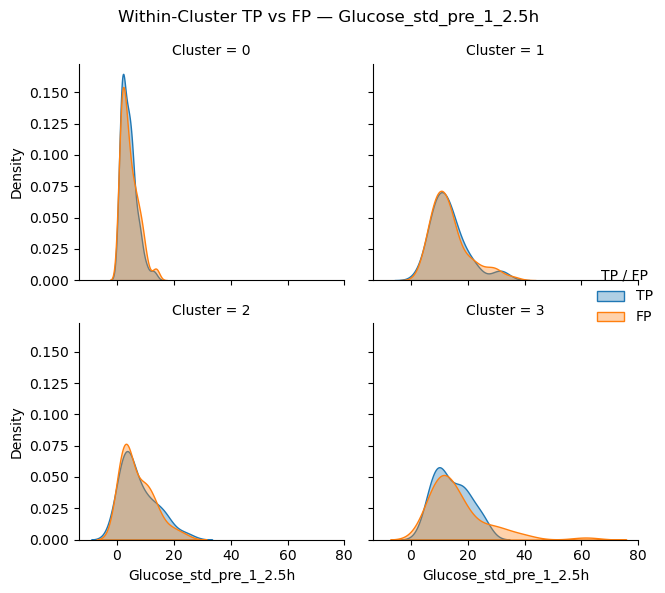

/opt/anaconda3/envs/jupyter_env/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/var/folders/r0/h30ywvr55x98xwjf49klh76m0000gp/T/ipykernel_14807/4216514217.py:31: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


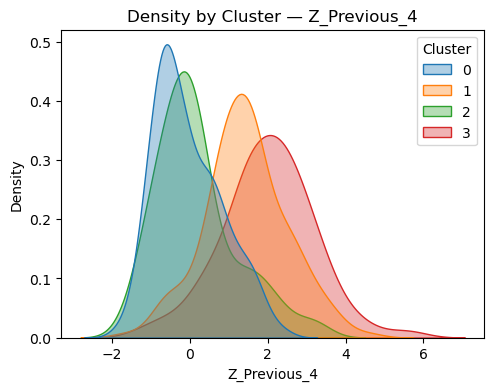

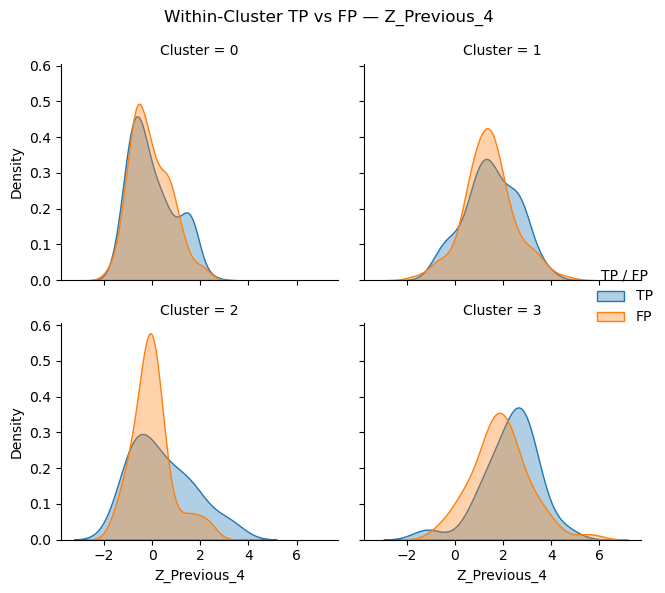

/opt/anaconda3/envs/jupyter_env/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/var/folders/r0/h30ywvr55x98xwjf49klh76m0000gp/T/ipykernel_14807/4216514217.py:31: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


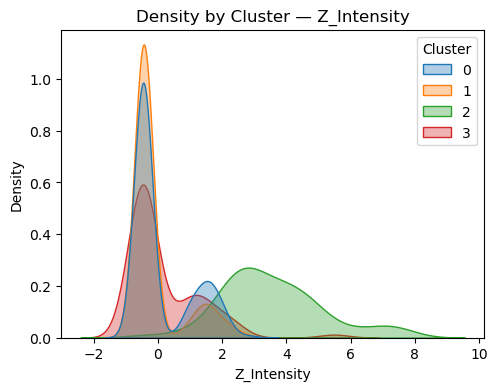

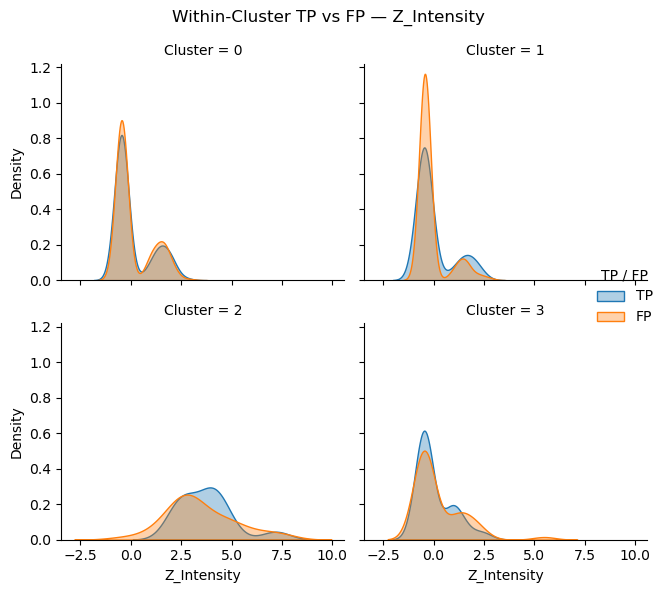

/opt/anaconda3/envs/jupyter_env/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/var/folders/r0/h30ywvr55x98xwjf49klh76m0000gp/T/ipykernel_14807/4216514217.py:31: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


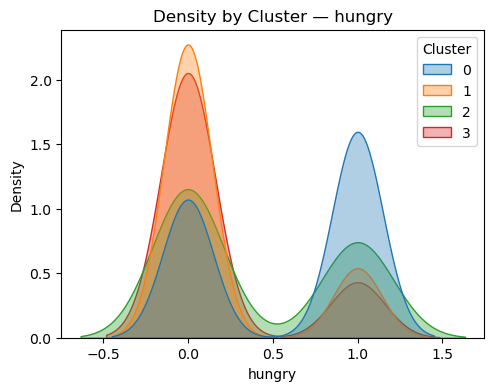

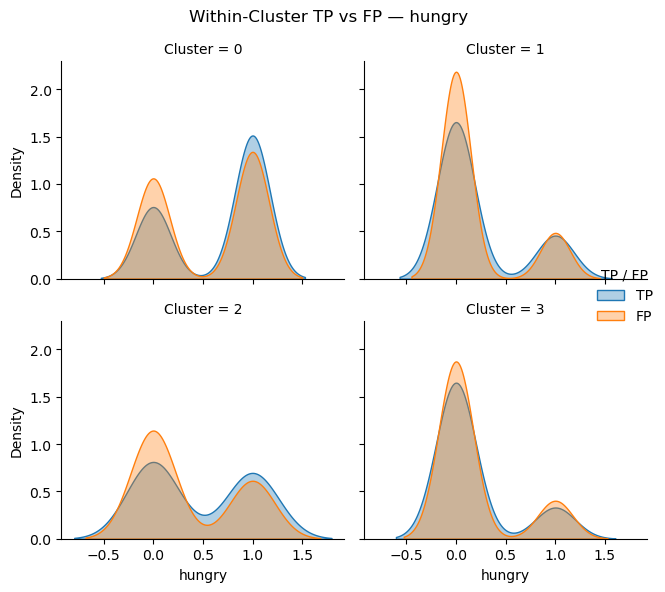

/opt/anaconda3/envs/jupyter_env/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/var/folders/r0/h30ywvr55x98xwjf49klh76m0000gp/T/ipykernel_14807/4216514217.py:31: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


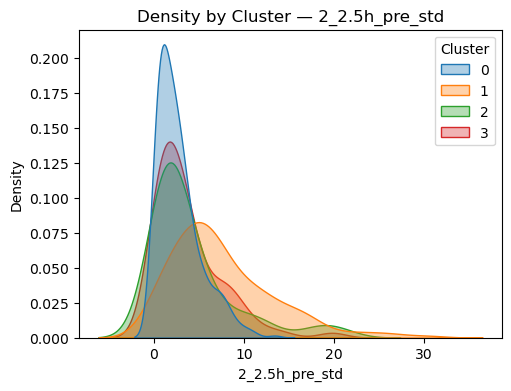

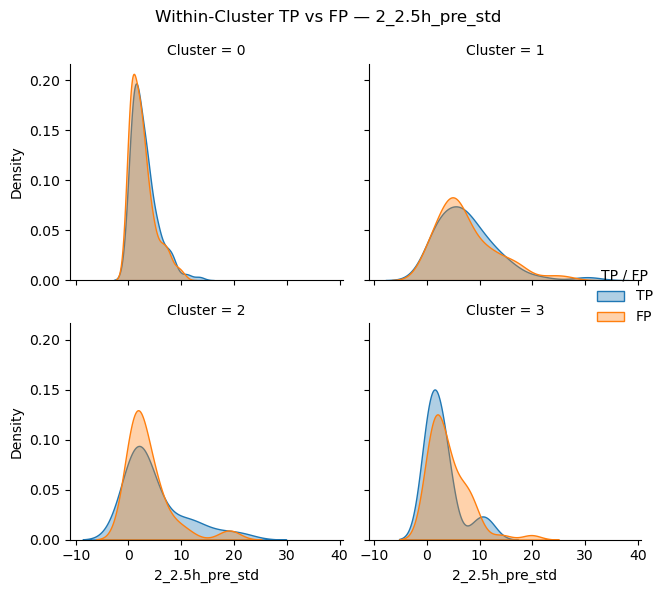

/opt/anaconda3/envs/jupyter_env/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/var/folders/r0/h30ywvr55x98xwjf49klh76m0000gp/T/ipykernel_14807/4216514217.py:31: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


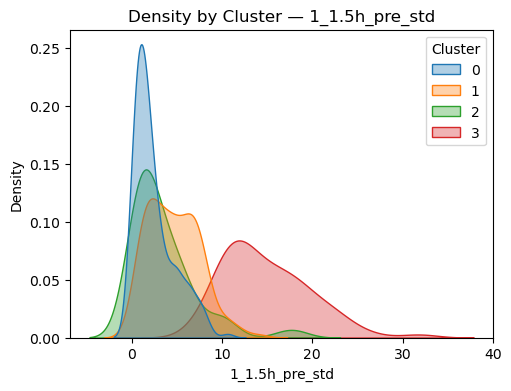

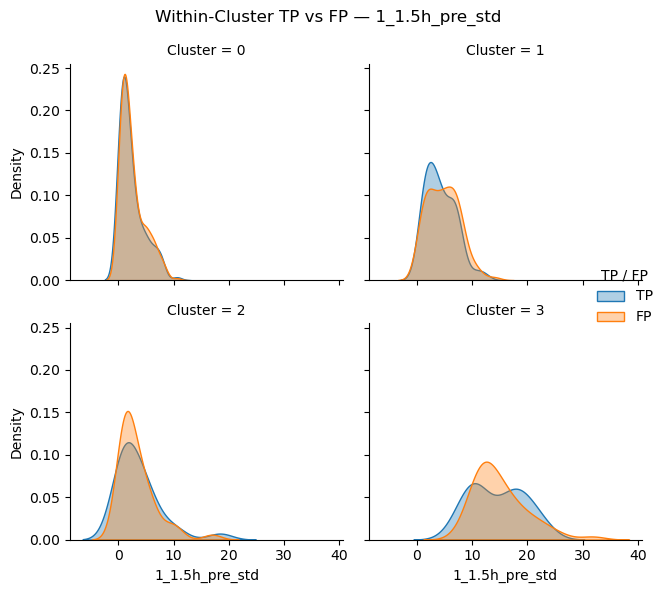

/opt/anaconda3/envs/jupyter_env/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/var/folders/r0/h30ywvr55x98xwjf49klh76m0000gp/T/ipykernel_14807/4216514217.py:31: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


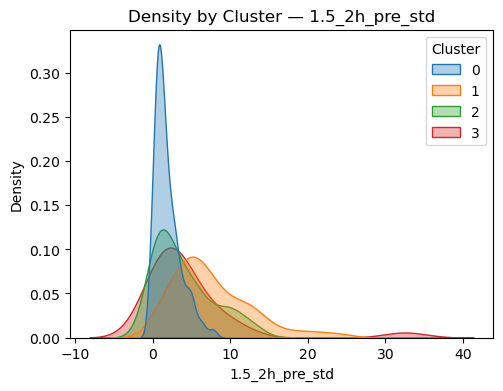

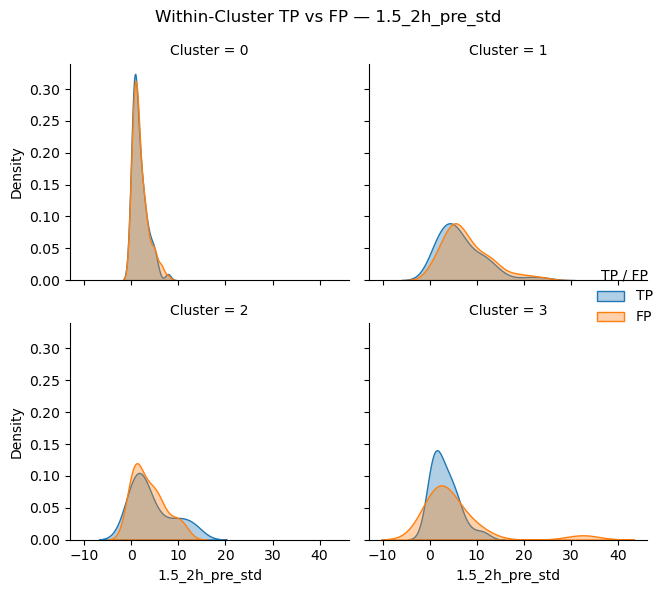

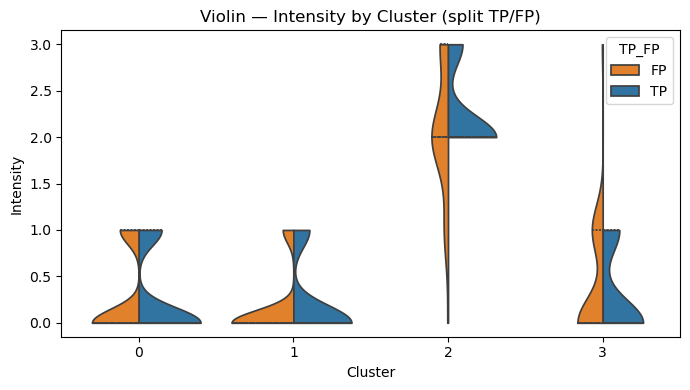

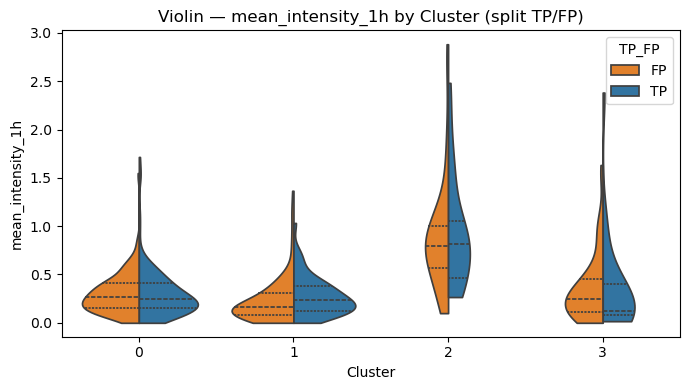

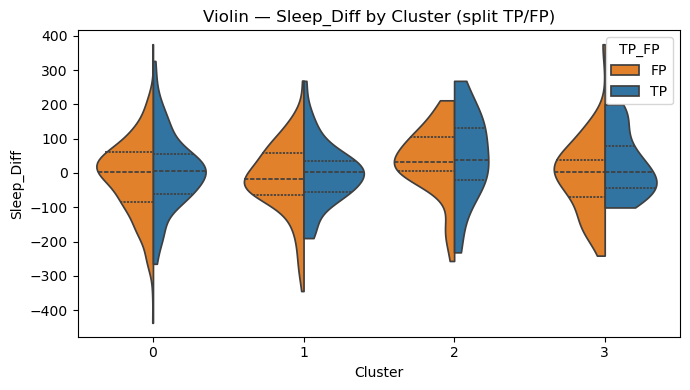

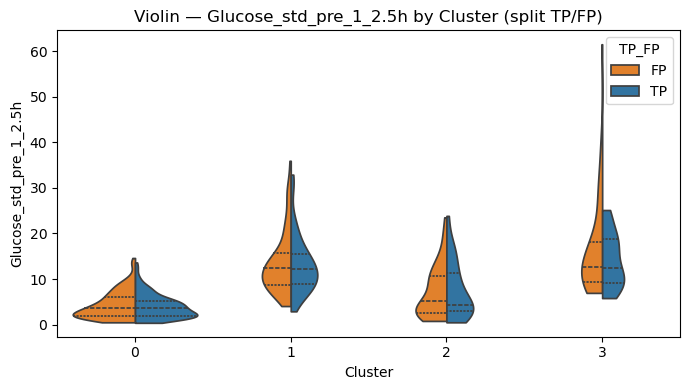

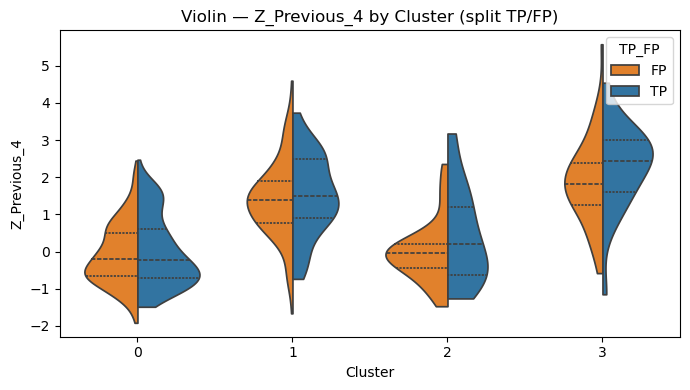

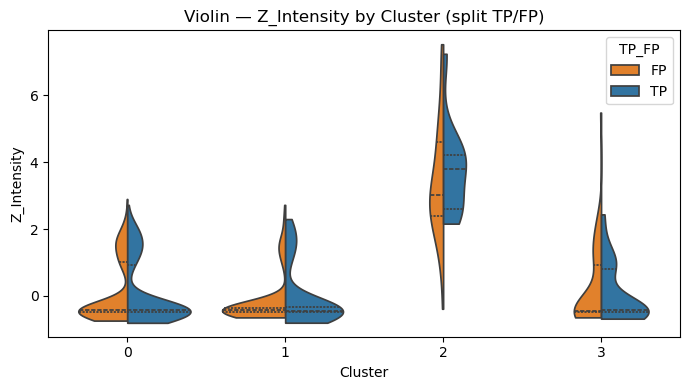

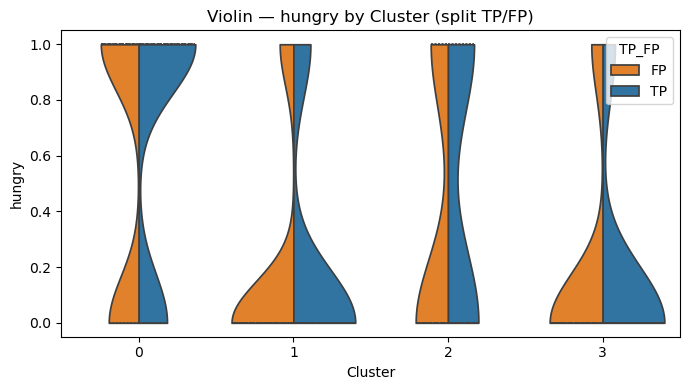

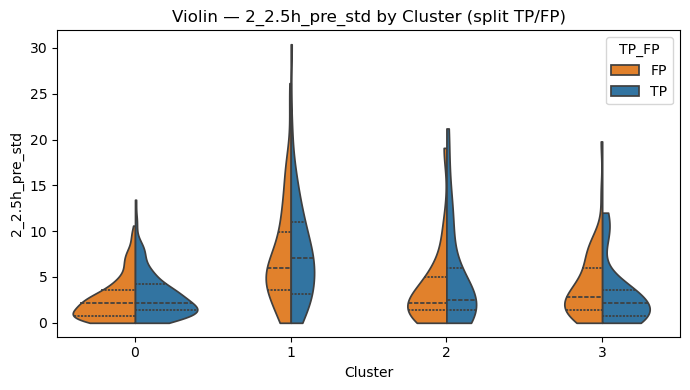

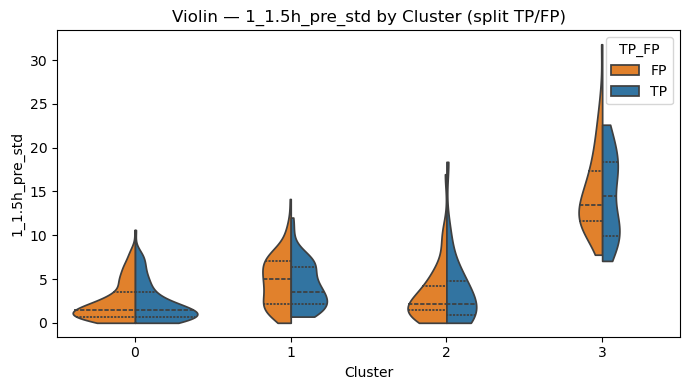

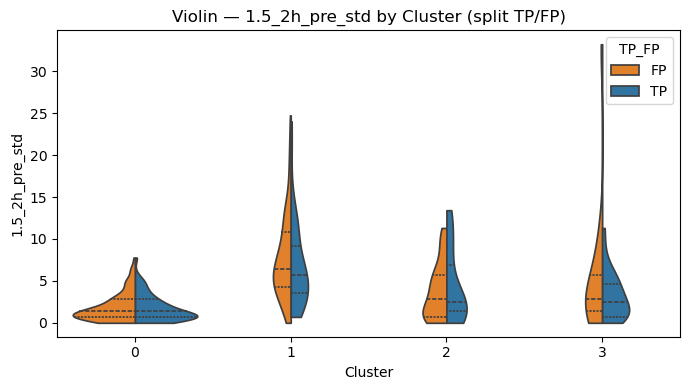

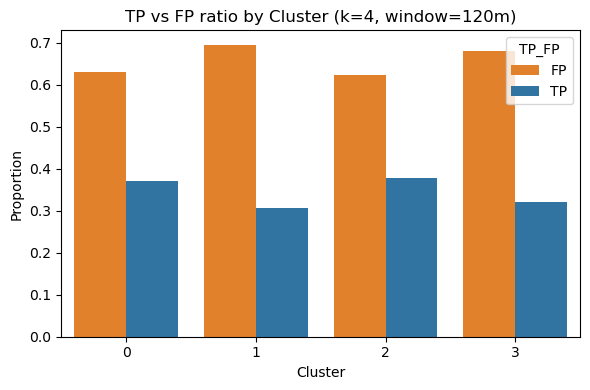

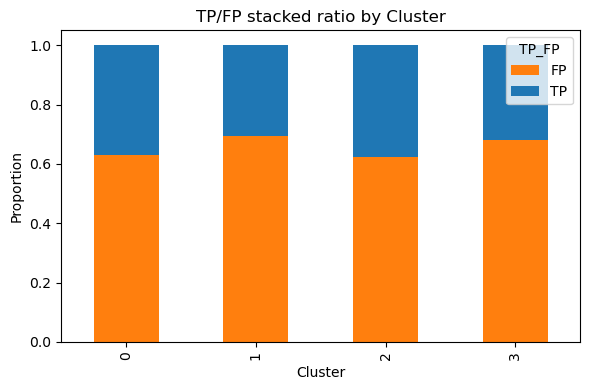

In [125]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 0) TP/FP 라벨 컬럼 (문자)
A = A.copy()
A["TP_FP"] = np.where(A["success_60m_dedup"] == 1, "TP", "FP")

pal_cluster = sns.color_palette("tab10", n_colors=A["Cluster"].nunique())
pal_tp = {"TP": "tab:blue", "FP": "tab:orange"}

# 1) 변수별: (좌) 클러스터 분포 / (우) 각 클러스터 내 TP vs FP 분포
for var in analysis_vars:
    fig = plt.figure(figsize=(12,4))

    # (좌) 클러스터별 겹쳐 그린 밀도
    ax1 = plt.subplot(1,2,1)
    sns.kdeplot(data=A, x=var, hue="Cluster",
                common_norm=False, fill=True, alpha=0.35, ax=ax1, palette=pal_cluster)
    ax1.set_title(f"Density by Cluster — {var}")

    # (우) 각 클러스터 패싯: TP vs FP
    g = sns.FacetGrid(A, col="Cluster", hue="TP_FP", col_wrap=2, height=3,
                      sharex=True, sharey=True, palette=pal_tp)
    g.map(sns.kdeplot, var, fill=True, alpha=0.35)
    g.add_legend(title="TP / FP")
    g.fig.subplots_adjust(top=0.85)
    g.fig.suptitle(f"Within-Cluster TP vs FP — {var}")

    plt.tight_layout()
    plt.show()

# 2) 보조 시각화: 클러스터별 TP/FP 바이올린(분포 형태 더 또렷)
for var in analysis_vars:
    plt.figure(figsize=(7,4))
    sns.violinplot(data=A, x="Cluster", y=var, hue="TP_FP",
                   split=True, inner="quartile", palette=pal_tp, cut=0)
    plt.title(f"Violin — {var} by Cluster (split TP/FP)")
    plt.tight_layout()
    plt.show()

# 3) 클러스터별 TP/FP 비율 바차트 (스택/옆배치 둘 다 제공)
summary_named = (A.groupby("Cluster")["TP_FP"]
                   .value_counts(normalize=True)
                   .rename("ratio")
                   .reset_index())

plt.figure(figsize=(6,4))
sns.barplot(data=summary_named, x="Cluster", y="ratio", hue="TP_FP", palette=pal_tp)
plt.ylabel("Proportion")
plt.title("TP vs FP ratio by Cluster (k=4, window=120m)")
plt.tight_layout()
plt.show()

# (스택 버전 원하면)
stack_tab = (A.groupby(["Cluster","TP_FP"]).size()
               .unstack("TP_FP", fill_value=0))
(stack_tab.div(stack_tab.sum(1), axis=0)).plot(kind="bar", stacked=True, figsize=(6,4),
                                               color=[pal_tp["FP"], pal_tp["TP"]])
plt.ylabel("Proportion")
plt.title("TP/FP stacked ratio by Cluster")
plt.tight_layout()
plt.show()


# SHAP values